# Kinematics

In [4]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import numpy as np
from math import cos, sin, pi, atan2, sqrt, acos
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib.lines import Line2D

from matplotlib import animation
from matplotlib import rc
from IPython.display import HTML

In [8]:
# when i call the animation, this will make it work
rc('animation', html='html5')

In [ ]:
# using gait, lets create the leg angles
# gait: cmd -> feet position for each step
# leg: feet pos -> servo angles for each step
# rplot -> plots each of those servo angles

data = {
    # [ length, (limits), offset]
    'coxa':   [52, [-90, 90], 150],
    'femur':  [90, [-90, 90], 150],   # fixme
    'tibia':  [89, [-90, 120], 220],  # fixme
    'tarsus': [90, [-90, 90], 150],

    # gait
    # Angles: 0.00 75.60 -120.39 -45.22
    'stand': [0, 75, -120, -45],  # this determines the neutral leg position
    # 'sit': [0, 90, -90, -90],

    # engine
    # 'serialPort': '/dev/tty.usbserial-A506BOT5'
}

leg = Leg4(data)  # 4 servo leg
gait = DiscreteRippleGait(65.0, leg.getNeutralPos())  # ripple gait

cmd = [1,0,0]                             # go straight
pts = gait.oneCycle_alt(cmd)              # array of 3d foot pts
angle = leg.generateServoAngles_alt(pts)  # array of leg servo angles

In [5]:
# remove this ... leg does it

def cosinelaw(a,b,c):
    # cos(g) = (a^2+b^2-c^2)/2ab
    return acos((a**2+b**2-c**2)/(2*a*b))

def inverse(x,y,z,o, degrees=True):
    """
    Azimuth angle is between x and w and lies in the x-y plane
    
               ^ x
         w     |
           \   |
         l1 \  |
             \ |
              \|
    <----------+ (z is out of the page - right hand rule)
    y
    
    Most of the leg moves in the plane defined by w-z
    
    ^ z      l3
    |      o-----o
    |     /       \ l4
    |    / l2      E
    |   /
    +--o-------------> w
     l1
     
    l1: coxa
    l2: femur
    l3: tibia
    l4: tarsus
     
    All joint angles returned are in degrees: (t1, t2, t3, t4)
    """
    # mm
    l1 = 52
    l2 = 89
    l3 = 90
    l4 = 95
    t1 = atan2(y,x)
    
    if degrees:
        o = o*pi/180
    
    w = sqrt(x**2+y**2)-l1
    j4w = w+l4*cos(o)
    j4z = z+l4*sin(o)
    r = sqrt(j4w**2+j4z**2)
    g1 = atan2(j4z,j4w)
    g2 = cosinelaw(l2,r,l3)
    t2 = g1+g2
    
    t3 = pi+cosinelaw(l2,l3,r)
    
    j2w=l2*cos(t2)
    j2z=l2*sin(t2)
    c=sqrt((w-j2w)**2+(z-j2z)**2)
    t4=pi+cosinelaw(l3,l4,c)
    
    if degrees:
        t1 *= 180/pi
        t2 *= 180/pi
        t3 *= 180/pi
        t4 *= 180/pi
    
    return (t1,t2,t3,t4)

# Animation

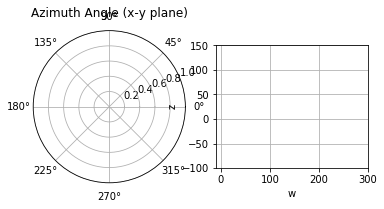

In [6]:
fig = plt.figure()

# radial plot 
ax1 = fig.add_subplot(1, 2, 1,projection='polar')
ax1.set_title('Azimuth Angle (x-y plane)')
# line1, = ax1.plot([], [], lw=2)
line1 = Line2D([], [], color='black')
ax1.add_line(line1)
# ax1.set_aspect('equal', 'datalim')

# scatter plot
ax2 = fig.add_subplot(1, 2, 2)
# line2, = ax2.plot([], [], lw=2)
line2 = Line2D([], [], color='black', linewidth=2)
ax2.set_xlabel('w')
ax2.set_ylabel('z')
ax2.add_line(line2)
ax2.set_xlim(-10, 300)
ax2.set_ylim(-100, 150)
ax2.set_aspect('equal')
ax2.grid()  # turn grid on


def rplot(t1, t2, t3, t4, degrees=True):
    """Given the 4 joint angles (in rads), plot the arm in the x-y and w-z planes

    x = (d2 + l1*cos(t2) + l2*cos(t2 + t3) + l3*cos(t2 + t3 + t4))*cos(t1)
    y = (d2 + l1*cos(t2) + l2*cos(t2 + t3) + l3*cos(t2 + t3 + t4))*sin(t1)
    z = l1*sin(t2) + l2*sin(t2 + t3) + l3*sin(t2 + t3 + t4)
    """
    l1 = 52
    l2 = 89
    l3 = 90
    l4 = 95

    ptsx = [0]
    ptsy = [0]

    if degrees:
        t1 *= pi/180
        t2 *= pi/180
        t3 *= pi/180
        t4 *= pi/180


    # our definition is reverse or these joints
    # link 1
    x0 = l1
    y0 = 0
    ptsx.append(x0)
    ptsy.append(y0)

    # link 2
    x1 = x0 + l2*cos(t2)
    y1 = y0 + l2*sin(t2)
    ptsx.append(x1)
    ptsy.append(y1)

    # link 3
    x2 = x1 + l3*cos(t2 + t3)
    y2 = y1 + l3*sin(t2 + t3)
    ptsx.append(x2)
    ptsy.append(y2)

    # link 4
    x3 = x2 + l4*cos(t2 + t3 + t4)
    y3 = y2 + l4*sin(t2 + t3 + t4)
    ptsx.append(x3)
    ptsy.append(y3)

    line1.set_data([0, t1], [0, 1.0])
    line2.set_data(ptsx, ptsy)
    return (line1, line2)

def plotLeg(x, y, z, orient):
    """Given a point (in inches) and orientation (in rads), this calculates
    the joint angles, then uses those angles to calculate the forward solution
    and prints out the error. It also plots the arm.
    """
    angles = inverse(x, y, z, orient)

    angles = list(angles)

    for i, a in enumerate(angles):
        if a > 180:
            angles[i] = -360 + a

    return rplot(*angles)

def animate(framedata):
    i = framedata
    print(i)
    pts = [
        [70,70,30,90],
        [70,70,0,90],
        [70,70,-10,90],
        [70,70,-50,90],
    ]
    pt = pts[i%len(pts)]
    
    return plotLeg(*pt)
        

In [11]:
# interval: time between frames in msec, default is 200
# frames: how many frames will be made for the movie loop
ani = animation.FuncAnimation(fig, animate, frames=4, interval=600, blit=True)
ani

0
0
0
1
2
3


In [ ]:
HTML(ani.to_html5_video())

In [ ]:
anim.save('mymovie.mp4')